In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import spaces
import gym
from stable_baselines3 import PPO

# ---------------------------
# 1. Create a Random Dataset
# ---------------------------
num_points = 1000
np.random.seed(40)
random_walk = np.cumsum(np.random.randn(num_points)) + 1000  

df_random = pd.DataFrame({'Close': random_walk})
df_random['Close_filtered'] = df_random['Close']  
# ---------------------------
# 2. Define a Simple Trading Environment
# ---------------------------
class RandomTradingEnv(gym.Env):
    def __init__(self, df, window_size=10):
        super(RandomTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.current_step = window_size
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(window_size, 1), dtype=np.float32)
        self.done = False
        self.balance = 0
        self.position = None  # None = No Position, 1 = Buy, -1 = Sell
        self.entry_price = 0
        self.trades = []  

    def _get_observation(self):
        obs = self.df['Close_filtered'].values[self.current_step - self.window_size:self.current_step]
        current_price = obs[-1]
        obs = obs / current_price
        return obs.reshape(-1, 1).astype(np.float32)

    def step(self, action):
        current_price = self.df['Close_filtered'].values[self.current_step - 1]
        next_price = self.df['Close_filtered'].values[self.current_step] if self.current_step < len(self.df) else current_price
        reward = 0

        if action == 1:  # Buy
            if self.position is None:
                self.position = 1
                self.entry_price = current_price
            elif self.position == -1:  # Closing short
                profit = self.entry_price - current_price
                reward = profit
                self.balance += profit
                self.trades.append(('Sell', self.entry_price, 'Win' if profit > 0 else 'Loss'))
                self.position = None

        elif action == 2:  # Sell
            if self.position is None:
                self.position = -1
                self.entry_price = current_price
            elif self.position == 1:  # Closing long
                profit = current_price - self.entry_price
                reward = profit
                self.balance += profit
                self.trades.append(('Buy', self.entry_price, 'Win' if profit > 0 else 'Loss'))
                self.position = None

        self.current_step += 1
        if self.current_step >= len(self.df):
            self.done = True

        obs = self._get_observation() if not self.done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, self.done, {}

    def reset(self):
        self.current_step = self.window_size
        self.done = False
        self.balance = 0
        self.position = None
        self.trades = []
        return self._get_observation()
# ---------------------------
# 3. Load the Model
# ---------------------------
model = PPO.load("adaptive_trading_bot2")
env_random = RandomTradingEnv(df_random, window_size=10)
model.set_env(env_random)

# ---------------------------
# 4. Run the Model and Track Trades
# ---------------------------
obs = env_random.reset()
done = False
actions = []
prices = []
profits = []
while not done:
    action, _ = model.predict(obs)
    actions.append(action)
    prices.append(env_random.df['Close_filtered'].values[env_random.current_step - 1])
    obs, reward, done, _ = env_random.step(action)
    profits.append(env_random.balance)

# ---------------------------
# 5. Visualizing Results
# ---------------------------
df_random['Action'] = actions + [0] * (len(df_random) - len(actions))
df_random['Profit'] = profits + [profits[-1]] * (len(df_random) - len(profits))

buy_signals = df_random[df_random['Action'] == 1]
sell_signals = df_random[df_random['Action'] == 2]

# --- Price Chart with Buy/Sell ---
plt.figure(figsize=(12, 5))
plt.plot(df_random['Close_filtered'], label='Close Price', color='blue')
plt.scatter(buy_signals.index, buy_signals['Close_filtered'], label='Buy', marker='^', color='green', alpha=0.8)
plt.scatter(sell_signals.index, sell_signals['Close_filtered'], label='Sell', marker='v', color='red', alpha=0.8)
plt.title('Buy/Sell Signals on Random Dataset')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()



# --- Profit Over Time ---
plt.figure(figsize=(12, 5))
plt.plot(df_random['Profit'], label='Cumulative Profit', color='purple')
plt.title('Cumulative Profit Over Time')
plt.xlabel('Time Step')
plt.ylabel('Profit')
plt.legend()
plt.show()

# Final Profit
print(f"Final Profit: {env_random.balance:.2f}")


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


ValueError: Observation spaces do not match: Box(-inf, inf, (10, 2), float32) != Box(-inf, inf, (10, 1), float32)

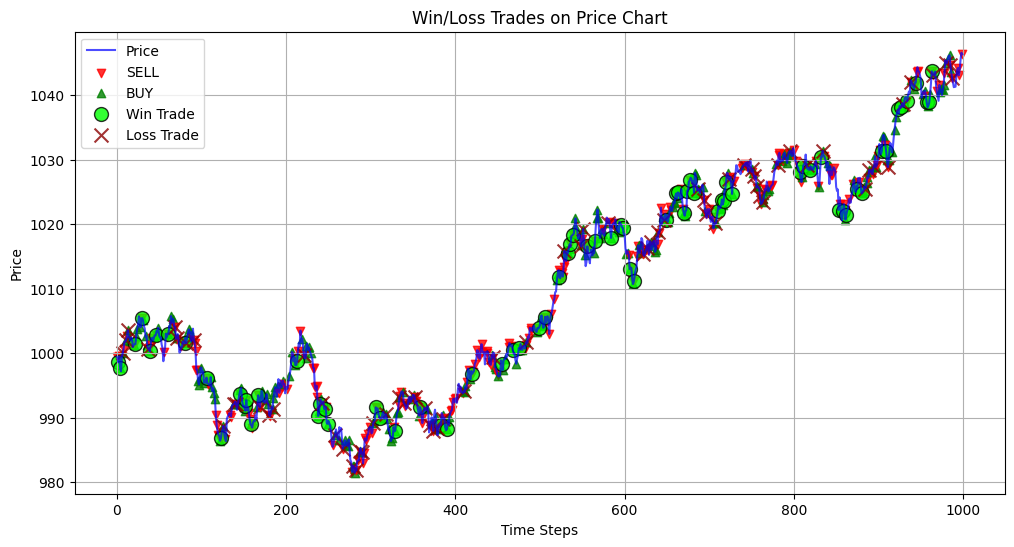

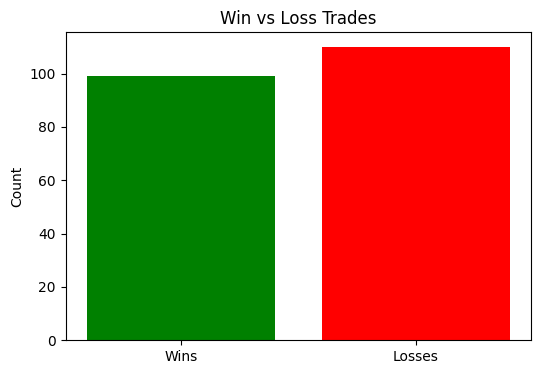

In [5]:
import numpy as np
import matplotlib.pyplot as plt

price_data = random_walk

# ---------------------------
# 2. Generate Random Trade Signals (BUY=1, SELL=-1, HOLD=0)
# ---------------------------
trade_actions = np.random.choice([1, -1, 0], size=len(price_data), p=[0.3, 0.3, 0.4])
trade_steps = np.where(trade_actions != 0)[0]  # Indices where BUY/SELL happened
trade_prices = price_data[trade_steps]  # Prices at trade points
trade_labels = ["BUY" if a == 1 else "SELL" for a in trade_actions[trade_steps]]

# Ensure trade_steps is a list of tuples (step, action, price)
trade_steps = list(zip(trade_steps, trade_labels, trade_prices))

# ---------------------------
# 3. Identify Win/Loss Trades
# ---------------------------
win_steps, win_prices = [], []
loss_steps, loss_prices = [], []

position = None  # Active trade position
entry_price = None

for trade in trade_steps:
    if isinstance(trade, tuple) and len(trade) == 3:
        step, action, price = trade  # Unpack safely
    else:
        print(f"Unexpected trade format: {trade}")
        continue  # Skip invalid trades

    if position is None:  # First trade
        position = action
        entry_price = price
    else:
        # Determine win/loss based on trade action
        if position == "BUY" and action == "SELL":
            if price > entry_price:
                win_steps.append(step)
                win_prices.append(price)
            else:
                loss_steps.append(step)
                loss_prices.append(price)
        elif position == "SELL" and action == "BUY":
            if price < entry_price:
                win_steps.append(step)
                win_prices.append(price)
            else:
                loss_steps.append(step)
                loss_prices.append(price)
        
        # Reset for next trade
        position = None  
        entry_price = None

# ---------------------------
# 4. Plot Buy/Sell & Win/Loss Signals
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(price_data, label="Price", color="blue", alpha=0.7)

# Plot BUY/SELL signals
for step, action, price in trade_steps:
    if action == "BUY":
        plt.scatter(step, price, marker='^', color='green', label="BUY" if "BUY" not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.8)
    elif action == "SELL":
        plt.scatter(step, price, marker='v', color='red', label="SELL" if "SELL" not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.8)

# Plot WIN/LOSS signals
plt.scatter(win_steps, win_prices, marker='o', color='lime', edgecolors='black', s=100, label="Win Trade", alpha=0.8)
plt.scatter(loss_steps, loss_prices, marker='x', color='darkred', s=100, label="Loss Trade", alpha=0.8)

# Final plot settings
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.title("Win/Loss Trades on Price Chart")
plt.grid()
plt.show()

# --- Win/Loss Bar Chart ---
wins = sum(1 for t in env_random.trades if t[2] == 'Win')
losses = sum(1 for t in env_random.trades if t[2] == 'Loss')

plt.figure(figsize=(6, 4))
plt.bar(['Wins', 'Losses'], [wins, losses], color=['green', 'red'])
plt.title('Win vs Loss Trades')
plt.ylabel('Count')
plt.show()

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


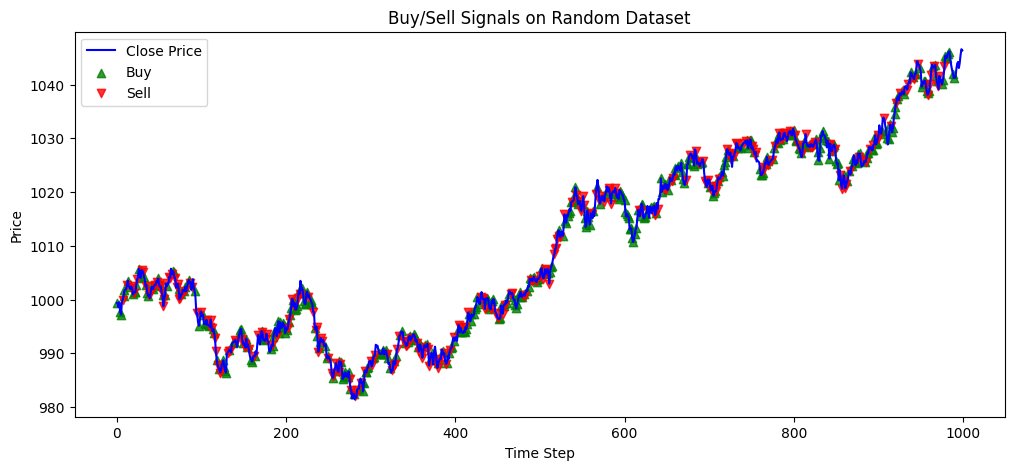

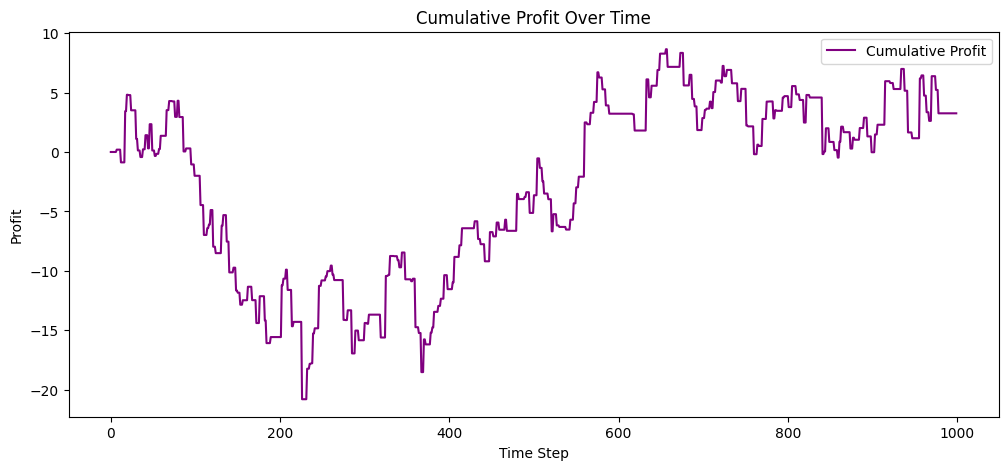

Final Profit: 3.25


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import spaces
import gym
from stable_baselines3 import PPO

# ---------------------------
# 1. Create a Random Dataset
# ---------------------------
# num_points = 1000
# np.random.seed(42)
# random_walk = np.cumsum(np.random.randn(num_points)) + 1000  

# df_random = pd.DataFrame({'Close': random_walk})
# df_random['Close_filtered'] = df_random['Close']  
# ---------------------------
# 2. Define a Simple Trading Environment
# ---------------------------
class RandomTradingEnv(gym.Env):
    def __init__(self, df, window_size=10):
        super(RandomTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.current_step = window_size
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(window_size, 1), dtype=np.float32)
        self.done = False
        self.balance = 0
        self.position = None  # None = No Position, 1 = Buy, -1 = Sell
        self.entry_price = 0
        self.trades = []  

    def _get_observation(self):
        obs = self.df['Close_filtered'].values[self.current_step - self.window_size:self.current_step]
        current_price = obs[-1]
        obs = obs / current_price
        return obs.reshape(-1, 1).astype(np.float32)

    def step(self, action):
        current_price = self.df['Close_filtered'].values[self.current_step - 1]
        next_price = self.df['Close_filtered'].values[self.current_step] if self.current_step < len(self.df) else current_price
        reward = 0

        if action == 1:  # Buy
            if self.position is None:
                self.position = 1
                self.entry_price = current_price
            elif self.position == -1:  # Closing short
                profit = self.entry_price - current_price
                reward = profit
                self.balance += profit
                self.trades.append(('Sell', self.entry_price, 'Win' if profit > 0 else 'Loss'))
                self.position = None

        elif action == 2:  # Sell
            if self.position is None:
                self.position = -1
                self.entry_price = current_price
            elif self.position == 1:  # Closing long
                profit = current_price - self.entry_price
                reward = profit
                self.balance += profit
                self.trades.append(('Buy', self.entry_price, 'Win' if profit > 0 else 'Loss'))
                self.position = None

        self.current_step += 1
        if self.current_step >= len(self.df):
            self.done = True

        obs = self._get_observation() if not self.done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, self.done, {}

    def reset(self):
        self.current_step = self.window_size
        self.done = False
        self.balance = 0
        self.position = None
        self.trades = []
        return self._get_observation()
# ---------------------------
# 3. Load the Model
# ---------------------------
model = PPO.load("adaptive_trading_bot")
env_random = RandomTradingEnv(df_random, window_size=10)
model.set_env(env_random)

# ---------------------------
# 4. Run the Model and Track Trades
# ---------------------------
obs = env_random.reset()
done = False
actions = []
prices = []
profits = []
while not done:
    action, _ = model.predict(obs)
    actions.append(action)
    prices.append(env_random.df['Close_filtered'].values[env_random.current_step - 1])
    obs, reward, done, _ = env_random.step(action)
    profits.append(env_random.balance)

# ---------------------------
# 5. Visualizing Results
# ---------------------------
df_random['Action'] = actions + [0] * (len(df_random) - len(actions))
df_random['Profit'] = profits + [profits[-1]] * (len(df_random) - len(profits))

buy_signals = df_random[df_random['Action'] == 1]
sell_signals = df_random[df_random['Action'] == 2]

# --- Price Chart with Buy/Sell ---
plt.figure(figsize=(12, 5))
plt.plot(df_random['Close_filtered'], label='Close Price', color='blue')
plt.scatter(buy_signals.index, buy_signals['Close_filtered'], label='Buy', marker='^', color='green', alpha=0.8)
plt.scatter(sell_signals.index, sell_signals['Close_filtered'], label='Sell', marker='v', color='red', alpha=0.8)
plt.title('Buy/Sell Signals on Random Dataset')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()



# --- Profit Over Time ---
plt.figure(figsize=(12, 5))
plt.plot(df_random['Profit'], label='Cumulative Profit', color='purple')
plt.title('Cumulative Profit Over Time')
plt.xlabel('Time Step')
plt.ylabel('Profit')
plt.legend()
plt.show()

# Final Profit
print(f"Final Profit: {env_random.balance:.2f}")


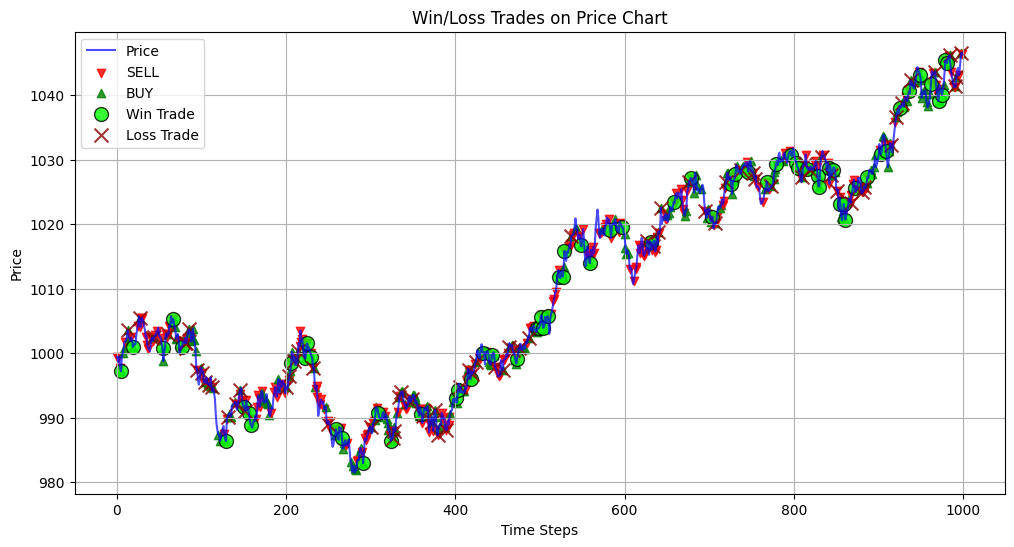

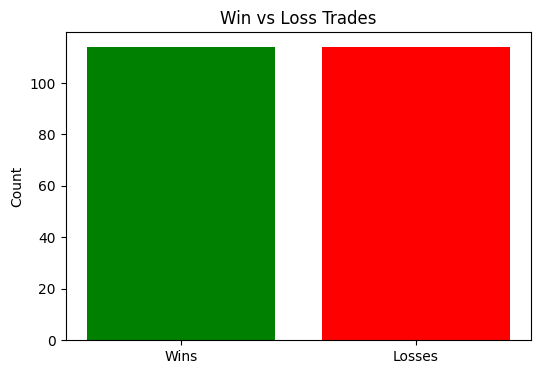

In [7]:
import numpy as np
import matplotlib.pyplot as plt

price_data = random_walk

# ---------------------------
# 2. Generate Random Trade Signals (BUY=1, SELL=-1, HOLD=0)
# ---------------------------
trade_actions = np.random.choice([1, -1, 0], size=len(price_data), p=[0.3, 0.3, 0.4])
trade_steps = np.where(trade_actions != 0)[0]  # Indices where BUY/SELL happened
trade_prices = price_data[trade_steps]  # Prices at trade points
trade_labels = ["BUY" if a == 1 else "SELL" for a in trade_actions[trade_steps]]

# Ensure trade_steps is a list of tuples (step, action, price)
trade_steps = list(zip(trade_steps, trade_labels, trade_prices))

# ---------------------------
# 3. Identify Win/Loss Trades
# ---------------------------
win_steps, win_prices = [], []
loss_steps, loss_prices = [], []

position = None  # Active trade position
entry_price = None

for trade in trade_steps:
    if isinstance(trade, tuple) and len(trade) == 3:
        step, action, price = trade  # Unpack safely
    else:
        print(f"Unexpected trade format: {trade}")
        continue  # Skip invalid trades

    if position is None:  # First trade
        position = action
        entry_price = price
    else:
        # Determine win/loss based on trade action
        if position == "BUY" and action == "SELL":
            if price > entry_price:
                win_steps.append(step)
                win_prices.append(price)
            else:
                loss_steps.append(step)
                loss_prices.append(price)
        elif position == "SELL" and action == "BUY":
            if price < entry_price:
                win_steps.append(step)
                win_prices.append(price)
            else:
                loss_steps.append(step)
                loss_prices.append(price)
        
        # Reset for next trade
        position = None  
        entry_price = None

# ---------------------------
# 4. Plot Buy/Sell & Win/Loss Signals
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(price_data, label="Price", color="blue", alpha=0.7)

# Plot BUY/SELL signals
for step, action, price in trade_steps:
    if action == "BUY":
        plt.scatter(step, price, marker='^', color='green', label="BUY" if "BUY" not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.8)
    elif action == "SELL":
        plt.scatter(step, price, marker='v', color='red', label="SELL" if "SELL" not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.8)

# Plot WIN/LOSS signals
plt.scatter(win_steps, win_prices, marker='o', color='lime', edgecolors='black', s=100, label="Win Trade", alpha=0.8)
plt.scatter(loss_steps, loss_prices, marker='x', color='darkred', s=100, label="Loss Trade", alpha=0.8)

# Final plot settings
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.title("Win/Loss Trades on Price Chart")
plt.grid()
plt.show()

# --- Win/Loss Bar Chart ---
wins = sum(1 for t in env_random.trades if t[2] == 'Win')
losses = sum(1 for t in env_random.trades if t[2] == 'Loss')

plt.figure(figsize=(6, 4))
plt.bar(['Wins', 'Losses'], [wins, losses], color=['green', 'red'])
plt.title('Win vs Loss Trades')
plt.ylabel('Count')
plt.show()

Best Parameters:
Short EMA Period: 5.0
Long EMA Period: 24.0
Cumulative Return: 1.02


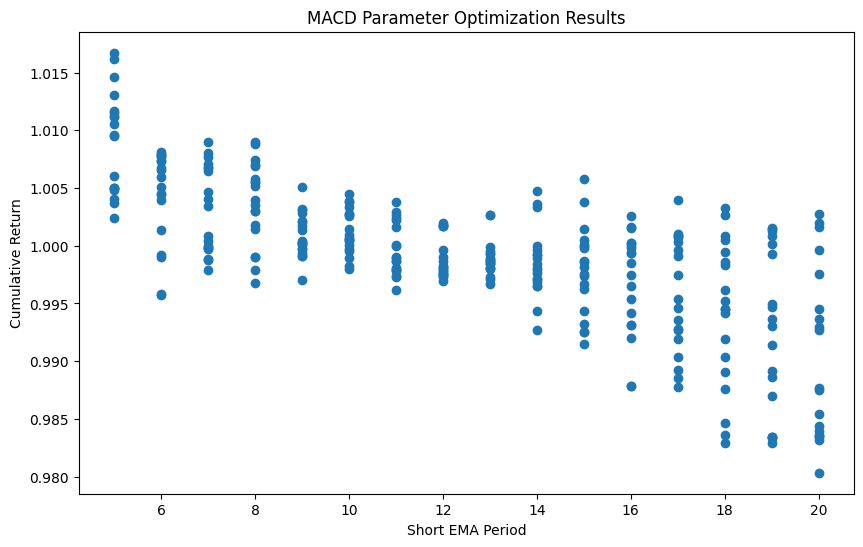

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_macd(data, short_period=12, long_period=26, signal_period=9):
    """
    Compute MACD indicators: MACD line and Signal line.
    """
    df = data.copy()
    df['EMA_short'] = df['Close'].ewm(span=short_period, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    return df

def backtest_macd_strategy(df):
    """
    A simple MACD crossover backtest:
      - Go long when MACD crosses above Signal.
      - Go short when MACD crosses below Signal.
    
    Returns the cumulative return of the strategy.
    """
    df = df.copy()
    # Create a position column: 1 for long, -1 for short.
    df['Position'] = np.where(df['MACD'] > df['Signal'], 1, -1)
    
    # Calculate daily market returns
    df['Market_Return'] = df['Close'].pct_change()
    
    # Strategy returns: use previous day's position to compute today's return
    df['Strategy_Return'] = df['Position'].shift(1) * df['Market_Return']
    
    # Calculate cumulative return
    cumulative_return = (1 + df['Strategy_Return'].fillna(0)).cumprod().iloc[-1]
    return cumulative_return

def optimize_macd_parameters(data, short_range, long_range, signal_period=9):
    """
    Iterate over different short and long EMA periods to see which combination yields the best cumulative return.
    Only considers combinations where short_period < long_period.
    
    Returns the best parameter combination and a list of all results.
    """
    results = []
    
    for short in short_range:
        for long in long_range:
            if short >= long:
                continue  # Ensure short EMA period is less than long EMA period
            df_macd = compute_macd(data, short_period=short, long_period=long, signal_period=signal_period)
            cum_return = backtest_macd_strategy(df_macd)
            results.append({'Short': short, 'Long': long, 'Cumulative Return': cum_return})
    
    results_df = pd.DataFrame(results)
    best_params = results_df.loc[results_df['Cumulative Return'].idxmax()]
    return best_params, results_df

# -------------------------------
# Example usage:
# -------------------------------

# Assume 'df' is a Pandas DataFrame with your historical data containing at least a 'Close' column.
# For example, load your data:
df = pd.read_csv('btc_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df = df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'})
# Define ranges for the short and long EMA periods.
short_range = range(5, 21, 1)     # e.g., from 5 to 20 days
long_range = range(22, 41, 1)      # e.g., from 22 to 40 days

# Run the optimization.
best_params, all_results = optimize_macd_parameters(df, short_range, long_range, signal_period=9)

print("Best Parameters:")
print(f"Short EMA Period: {best_params['Short']}")
print(f"Long EMA Period: {best_params['Long']}")
print(f"Cumulative Return: {best_params['Cumulative Return']:.2f}")

# Optionally, you can inspect all_results DataFrame or plot the performance
plt.figure(figsize=(10, 6))
plt.plot(all_results['Short'], all_results['Cumulative Return'], 'o')
plt.xlabel('Short EMA Period')
plt.ylabel('Cumulative Return')
plt.title('MACD Parameter Optimization Results')
plt.show()


Best Parameters:
Short EMA Period: 17.0
Long EMA Period: 23.0
Cumulative Return: 1.03


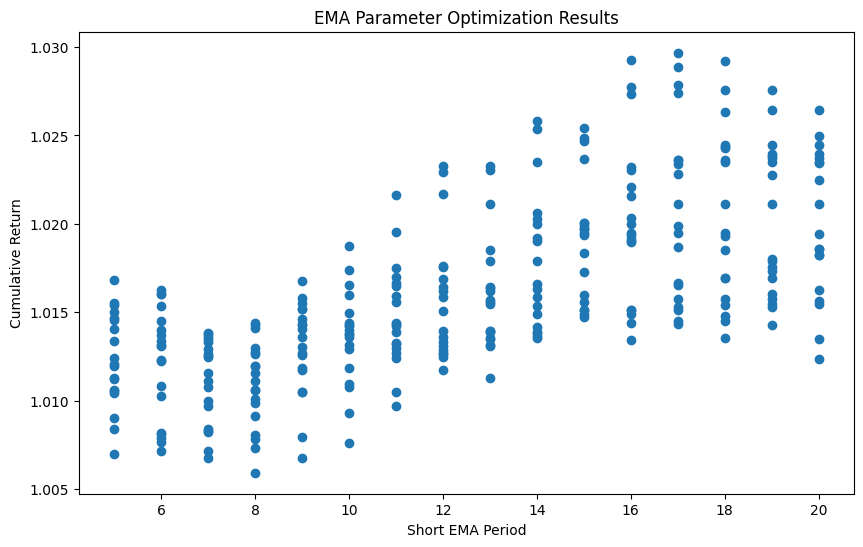

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_ema(data, short_period=12, long_period=26):
    """
    Compute short-term and long-term EMAs.
    """
    df = data.copy()
    df['EMA_short'] = df['Close'].ewm(span=short_period, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    return df

def backtest_ema_strategy(df):
    """
    A simple EMA crossover backtest:
      - Go long when short EMA crosses above long EMA.
      - Go short when short EMA crosses below long EMA.
    
    Returns the cumulative return of the strategy.
    """
    df = df.copy()
    df['Position'] = np.where(df['EMA_short'] > df['EMA_long'], 1, -1)  # 1 = long, -1 = short
    
    # Calculate daily market returns
    df['Market_Return'] = df['Close'].pct_change()
    
    # Strategy returns: use previous day's position to compute today's return
    df['Strategy_Return'] = df['Position'].shift(1) * df['Market_Return']
    
    # Calculate cumulative return
    cumulative_return = (1 + df['Strategy_Return'].fillna(0)).cumprod().iloc[-1]
    return cumulative_return

def optimize_ema_parameters(data, short_range, long_range):
    """
    Iterate over different short and long EMA periods to see which combination yields the best cumulative return.
    Ensures that short_period < long_period.
    
    Returns the best parameter combination and a list of all results.
    """
    results = []
    
    for short in short_range:
        for long in long_range:
            if short >= long:
                continue  # Ensure short EMA period is less than long EMA period
            
            df_ema = compute_ema(data, short_period=short, long_period=long)
            cum_return = backtest_ema_strategy(df_ema)
            results.append({'Short': short, 'Long': long, 'Cumulative Return': cum_return})
    
    results_df = pd.DataFrame(results)
    best_params = results_df.loc[results_df['Cumulative Return'].idxmax()]
    return best_params, results_df

# -------------------------------
# Example usage:
# -------------------------------

# Assume 'df' is a Pandas DataFrame with your historical data containing at least a 'Close' column.
# Example: df = pd.read_csv('your_data.csv', parse_dates=True, index_col='Date')

# Define ranges for the short and long EMA periods.
short_range = range(5, 21, 1)     # e.g., from 5 to 20 days
long_range = range(22, 41, 1)     # e.g., from 22 to 40 days

# Run the optimization.
best_params, all_results = optimize_ema_parameters(df, short_range, long_range)

print("Best Parameters:")
print(f"Short EMA Period: {best_params['Short']}")
print(f"Long EMA Period: {best_params['Long']}")
print(f"Cumulative Return: {best_params['Cumulative Return']:.2f}")

# Optionally, visualize the results
plt.figure(figsize=(10, 6))
plt.plot(all_results['Short'], all_results['Cumulative Return'], 'o')
plt.xlabel('Short EMA Period')
plt.ylabel('Cumulative Return')
plt.title('EMA Parameter Optimization Results')
plt.show()


Total Trades: 0
Wins: 0
Losses: 0
Win Rate: 0.00%
Empty DataFrame
Columns: []
Index: []


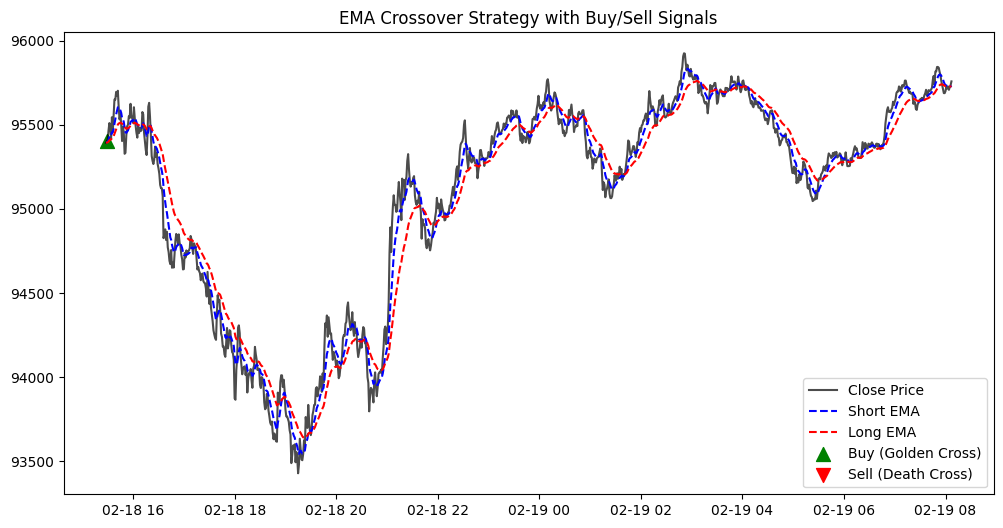

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_ema(data, short_period=12, long_period=26):
    """
    Compute short-term and long-term EMAs.
    """
    df = data.copy()
    df['EMA_short'] = df['Close'].ewm(span=short_period, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    return df

def generate_signals(df):
    """
    Generate Buy (Golden Cross) and Sell (Death Cross) signals.
    """
    df = df.copy()
    df['Signal'] = 0  # Default no signal
    df.loc[df['EMA_short'] > df['EMA_long'], 'Signal'] = 1  # Buy Signal (Golden Cross)
    df.loc[df['EMA_short'] < df['EMA_long'], 'Signal'] = -1  # Sell Signal (Death Cross)

    # Find crossovers (where Signal changes)
    df['Trade_Signal'] = df['Signal'].diff()
    
    # Identify Buy and Sell signals
    df['Buy_Signal'] = np.where(df['Trade_Signal'] == 1, df['Close'], np.nan)
    df['Sell_Signal'] = np.where(df['Trade_Signal'] == -1, df['Close'], np.nan)
    
    return df

def evaluate_trades(df):
    """
    Calculate win/loss for every buy-sell pair.
    """
    trades = []
    entry_price = None
    entry_index = None

    for i, row in df.iterrows():
        if row['Trade_Signal'] == 1:  # Buy Signal (Entry)
            entry_price = row['Close']
            entry_index = i
        elif row['Trade_Signal'] == -1 and entry_price is not None:  # Sell Signal (Exit)
            exit_price = row['Close']
            trade_result = 'Win' if exit_price > entry_price else 'Loss'
            trades.append({'Entry_Index': entry_index, 'Entry_Price': entry_price, 
                           'Exit_Index': i, 'Exit_Price': exit_price, 'Result': trade_result})
            entry_price = None  # Reset entry after closing position
    
    # If no trades are found, return an empty DataFrame and zero stats
    if len(trades) == 0:
        return pd.DataFrame(), 0, 0, 0, 0
    
    trade_df = pd.DataFrame(trades)
    
    # Ensure that the 'Result' column exists and calculate the win/loss stats
    trade_df['Result'] = trade_df['Result'].fillna('Loss')  # In case there are NaN results
    
    total_trades = len(trade_df)
    wins = (trade_df['Result'] == 'Win').sum()
    losses = (trade_df['Result'] == 'Loss').sum()
    win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0

    return trade_df, total_trades, wins, losses, win_rate


def plot_signals(df):
    """
    Plot price with EMA and Buy/Sell signals.
    """
    plt.figure(figsize=(12, 6))
    
    plt.plot(df['Close'], label='Close Price', color='black', alpha=0.7)
    plt.plot(df['EMA_short'], label='Short EMA', color='blue', linestyle='dashed')
    plt.plot(df['EMA_long'], label='Long EMA', color='red', linestyle='dashed')

    plt.scatter(df.index, df['Buy_Signal'], label='Buy (Golden Cross)', marker='^', color='green', s=100)
    plt.scatter(df.index, df['Sell_Signal'], label='Sell (Death Cross)', marker='v', color='red', s=100)

    plt.title('EMA Crossover Strategy with Buy/Sell Signals')
    plt.legend()
    plt.show()

# ---------------------------------
# Example usage:
# ---------------------------------

# Load data (ensure it has a 'Close' column)
# df = pd.read_csv('your_data.csv', parse_dates=True, index_col='Date')

# Define EMA periods
short_period = 10
long_period = 30

# Compute EMA and signals
df = compute_ema(df, short_period, long_period)
df = generate_signals(df)

# Evaluate trades
trade_results, total_trades, wins, losses, win_rate = evaluate_trades(df)

# Print trade statistics
print(f"Total Trades: {total_trades}")
print(f"Wins: {wins}")
print(f"Losses: {losses}")
print(f"Win Rate: {win_rate:.2f}%")

# Display trade results
print(trade_results)

# Plot signals on the price chart
plot_signals(df)
